## CSCI 632 ML Homework 7: Trees and Forests

**Instructions**

* **Insert all code, plots, results, and discussion** into this Jupyter Notebook.
* Your homework should be submitted as a **single Jupyter Notebook** (.ipynb file).
* While working, you use Google Colab by uploading this notebook and performing work there. Once complete, export the notebook as a Jupyter Notebook (.ipynb) and submit it to **Blackboard.**

You can answer mathematical questions either by:
* using LaTeX in a markdown cell, or
* pasting a scanned or photographed handwritten answer.

Aside: In the future I need to increase the size of the data sets so as to 
make the answer not quite so trivial.  A single decision tree can
accurately (100%) classify the spam_test.csv data set.

---
Utility functions

In [62]:
from IPython.display import Markdown, Math, display
import inspect
from jinja2 import Template, StrictUndefined

def md(string, strict: bool = True):
    frame = inspect.currentframe().f_back
    ctx = {**frame.f_globals, **frame.f_locals}

    T = Template(string, undefined=StrictUndefined if strict else None)
    display(Markdown(T.render(**ctx)))

def numpy_to_latex_matrix(matrix):
    latex_str = r'\begin{bmatrix}'
    for row in matrix:
        latex_str += ' & '.join(map(str, row)) + r' \\'
    latex_str += r'\end{bmatrix}'
    return latex_str

def print_matrix(matrix):
    display(Math(numpy_to_latex_matrix(matrix)))


---
### Problem 1

Let X be the dataset at a node and $Y \in \text{labels}$ the class label.
For a split $\sigma$ (e.g., a threshold on a feature or a categorical partition):

$$\mathrm{IG}(X,\sigma) \;=\; H(Y)\;-\;H(Y\mid \sigma),$$

where

$$H(Y) \;=\; -\sum_{y} P(Y=y)\log_2 P(Y=y), \qquad
H(Y\mid \sigma)\;=\;\sum_{b} \Pr(B_b)\, H\!\left(Y\,\big|\,B_b\right)
\;=\;\sum_{b} \frac{|X_b|}{|X|}\,H(Y_{X_b}).$$

Here $B_b$ indexes the branches (children) produced by $\sigma$, $X_b$ is
the subset of $X$ in branch $b$, and $Y_{X_b}$ are the labels restricted
to $X_b$. Use base-2 logs.  You can see examples in lecture 16's notes.

Consider the case of an email spam detector:
`Y = Spam?` (`+` = spam, `-` = not spam)

$X$ has 14 items with class counts $(n_{+}, n_{-}) = (9,5)$.


| id | HasAttachment | SenderDomainType | Y |
|----|----------------|------------------|---|
|  1 | 0 | free      | + |
|  2 | 1 | free      | + |
|  3 | 0 | free      | - |
|  4 | 1 | free      | - |
|  5 | 0 | corporate | + |
|  6 | 0 | corporate | + |
|  7 | 1 | corporate | + |
|  8 | 0 | corporate | + |
|  9 | 1 | corporate | - |
| 10 | 0 | unknown   | + |
| 11 | 0 | unknown   | + |
| 12 | 0 | unknown   | - |
| 13 | 1 | unknown   | + |
| 14 | 1 | unknown   | - |


$H(Y) = -(\tfrac{9}{14} \log_2 \tfrac{9}{14} + \tfrac{5}{14} \log_2 \tfrac{5}{14}) \approx 0.9403$



(a) Compute the entropy $H(Y|\text{HasAttachment})$ and IG for the `HasAttachment` feature.


**Answer**

* 6 have attachments.
* 8 do not.

$$H(Y|\text{HasAttachment}) = \frac{6}{14} H_{have} + \frac{8}{14} H_{not}$$

Of the 6 with attachments, 3 were spam.

$$H_{have} = -\left(\frac{3}{6} \log \frac{3}{6} + \frac{3}{6} \log \frac{3}{6}\right) = 1$$

Of the 8 without attachments, 6 were spam.

$$H_{not} = -\left(\frac{6}{8} \log \frac{6}{8} + \frac{2}{8} \log \frac{2}{8}\right) \approx 0.811$$



In [63]:
from math import log2

H_y = - (9/14 * log2(9/14) + 5/14 * log2(5/14))
print("H_y:", H_y)
p1 = 6/8
p2 = 2/8
H_not = - (p1 * log2(p1) + p2 * log2(p2))
print("H_not:", H_not)
H_y_att = 6/14 * 1 + 8/14 * Hnot
print("H_y_att:", H_y_att)
IG = H_y - H_y_att
print("IG:", IG)


H_y: 0.9402859586706311
H_not: 0.8112781244591328
H_y_att: 0.8921589282623617
IG: 0.04812703040826949


$$H(Y|\text{HasAttachment}) = \frac{6}{14} + \frac{8}{14} \cdot 0.811 \approx \boxed{0.892}$$

Information Gain (IG) is the difference between the entropy and the conditional entropy after making the decision.

$$IG = H(Y) - H(Y|\text{HasAttachment}) \approx \boxed{0.048}$$




(b) There are three ways to group sender domain types into a single binary decision: 
- $\sigma_{\texttt{free}}$:“In free?” vs “corporate or unknown”
- $\sigma_{\texttt{corporate}}$: “In corporate?” vs “free or unknown”
- $\sigma_{\texttt{unknown}}$: “In unknown?” vs “free or corporate”

For each decision $\sigma$ above, compute $H(Y\mid \sigma)$ and 
$\mathrm{IG}(X,\sigma)$. Report all three values.


**Answer**


In [64]:
# 4 out of 12 are free, 2 spam, 2 not.
H_free = - (2/4 * log2(2/4) + 2/4 * log2(2/4))
H_not_free = - (3/10 * log2(3/10) + 7/10 * log2(7/10))
H_given_free = 4/14 * H_free + 10/14 * H_not_free

md(r"""
   For the decision $\sigma_{\text{free}}$:
   
   $$H(Y) = {{H_y| round(4)}}$$
   $$H(Y|\text{free}) = \frac{4}{14} \cdot H_{\text{free}} + \frac{10}{14} \cdot H_{\text{not free}}$$

   $$H_{\text{free}} = - \left( \frac{2}{4} \log_2{\frac{2}{4}} + \frac{2}{4} \log_2{\frac{2}{4}} \right) = 1$$

   $$H_{\text{not free}} = - \left( \frac{3}{10} \log_2{\frac{3}{10}} + 
                             \frac{7}{10} \log_2{\frac{7}{10}} \right) \approx {{H_not_free| round(4)}}$$
   
   $$H(Y|\text{free}) \approx \boxed{ {{H_given_free| round(4)}} }$$

   $$IG(X, \text{free}) = H(Y) - H(Y|\text{free}) \approx \boxed{ {{(H_y - H_given_free)| round(4)}} }$$
   """
   )



   For the decision $\sigma_{\text{free}}$:
   
   $$H(Y) = 0.9403$$
   $$H(Y|\text{free}) = \frac{4}{14} \cdot H_{\text{free}} + \frac{10}{14} \cdot H_{\text{not free}}$$

   $$H_{\text{free}} = - \left( \frac{2}{4} \log_2{\frac{2}{4}} + \frac{2}{4} \log_2{\frac{2}{4}} \right) = 1$$

   $$H_{\text{not free}} = - \left( \frac{3}{10} \log_2{\frac{3}{10}} + 
                             \frac{7}{10} \log_2{\frac{7}{10}} \right) \approx 0.8813$$
   
   $$H(Y|\text{free}) \approx \boxed{ 0.9152 }$$

   $$IG(X, \text{free}) = H(Y) - H(Y|\text{free}) \approx \boxed{ 0.0251 }$$
   

In [65]:

H_corp = - (4/5 * log2(4/5) + 1/5 * log2(1/5))
H_not_corp = - (5/9 * log2(5/9) + 4/9 * log2(4/9))
H_given_corp = 5/14 * H_corp + 9/14 * H_not_corp

md(r"""
   For the decision $\sigma_{\text{corporate}}$:
   
   $$H(Y) = {{H_y| round(4)}}$$
   $$H(Y|\text{corporate}) = \frac{5}{14} \cdot H_{\text{corporate}} + \frac{9}{14} \cdot H_{\text{not corporate}}$$

   $$H_{\text{corporate}} = - \left( \frac{4}{5} \log_2{\frac{4}{5}} + \frac{1}{5} \log_2{\frac{1}{5}} \right) \approx {{H_corp| round(4)}}$$

   $$H_{\text{not corporate}} = - \left( \frac{5}{9} \log_2{\frac{5}{9}} + 
                             \frac{4}{9} \log_2{\frac{4}{9}} \right) \approx {{H_not_corp| round(4)}}$$

   $$H(Y|\text{corporate}) \approx \boxed{ {{H_given_corp| round(4)}} }$$

   $$IG(X, \text{corporate}) = H(Y) - H(Y|\text{corporate}) \approx \boxed{ {{(H_y - H_given_corp)| round(4)}} }$$
   """
   )



   For the decision $\sigma_{\text{corporate}}$:
   
   $$H(Y) = 0.9403$$
   $$H(Y|\text{corporate}) = \frac{5}{14} \cdot H_{\text{corporate}} + \frac{9}{14} \cdot H_{\text{not corporate}}$$

   $$H_{\text{corporate}} = - \left( \frac{4}{5} \log_2{\frac{4}{5}} + \frac{1}{5} \log_2{\frac{1}{5}} \right) \approx 0.7219$$

   $$H_{\text{not corporate}} = - \left( \frac{5}{9} \log_2{\frac{5}{9}} + 
                             \frac{4}{9} \log_2{\frac{4}{9}} \right) \approx 0.9911$$

   $$H(Y|\text{corporate}) \approx \boxed{ 0.895 }$$

   $$IG(X, \text{corporate}) = H(Y) - H(Y|\text{corporate}) \approx \boxed{ 0.0453 }$$
   

In [66]:
H_unknown = - (3/5 * log2(3/5) + 2/5 * log2(2/5))
H_not_unknown = - (6/9 * log2(6/9) + 3/9 * log2(3/9))
H_given_unknown = 5/14 * H_unknown + 9/14 * H_not_unknown

md(r"""
   For the decision $\sigma_{\text{unknown}}$:

   $$H(Y) = {{H_y| round(4)}}$$
   $$H(Y|\text{unknown}) = \frac{5}{14} \cdot H_{\text{unknown}} + \frac{9}{14} \cdot H_{\text{not unknown}}$$

   $$H_{\text{unknown}} = - \left( \frac{3}{5} \log_2{\frac{3}{5}} + \frac{2}{5} \log_2{\frac{2}{5}} \right) \approx {{H_unknown| round(4)}}$$

   $$H_{\text{not unknown}} = - \left( \frac{6}{9} \log_2{\frac{6}{9}} + 
                             \frac{3}{9} \log_2{\frac{3}{9}} \right) \approx {{H_not_unknown| round(4)}}$$

   $$H(Y|\text{unknown}) \approx \boxed{ {{H_given_unknown| round(4)}} }$$

   $$IG(X, \text{unknown}) = H(Y) - H(Y|\text{unknown}) \approx \boxed{ {{(H_y - H_given_unknown)| round(4)}} }$$
   """
   )



   For the decision $\sigma_{\text{unknown}}$:

   $$H(Y) = 0.9403$$
   $$H(Y|\text{unknown}) = \frac{5}{14} \cdot H_{\text{unknown}} + \frac{9}{14} \cdot H_{\text{not unknown}}$$

   $$H_{\text{unknown}} = - \left( \frac{3}{5} \log_2{\frac{3}{5}} + \frac{2}{5} \log_2{\frac{2}{5}} \right) \approx 0.971$$

   $$H_{\text{not unknown}} = - \left( \frac{6}{9} \log_2{\frac{6}{9}} + 
                             \frac{3}{9} \log_2{\frac{3}{9}} \right) \approx 0.9183$$

   $$H(Y|\text{unknown}) \approx \boxed{ 0.9371 }$$

   $$IG(X, \text{unknown}) = H(Y) - H(Y|\text{unknown}) \approx \boxed{ 0.0032 }$$
   


(c) Draw the binary decision tree for the feature-splits that maximizes IG at each interior
node. Include the class posterior probabilities and class label for each leaf.  Stop
when no split yields positive gain.

**Answer**

This is a case where a decision tree essentially fails.  It can provide no reasonable answer, but the answer is essentially random.   An entropy of 1?  This means that 50% of the values fall on either side.  

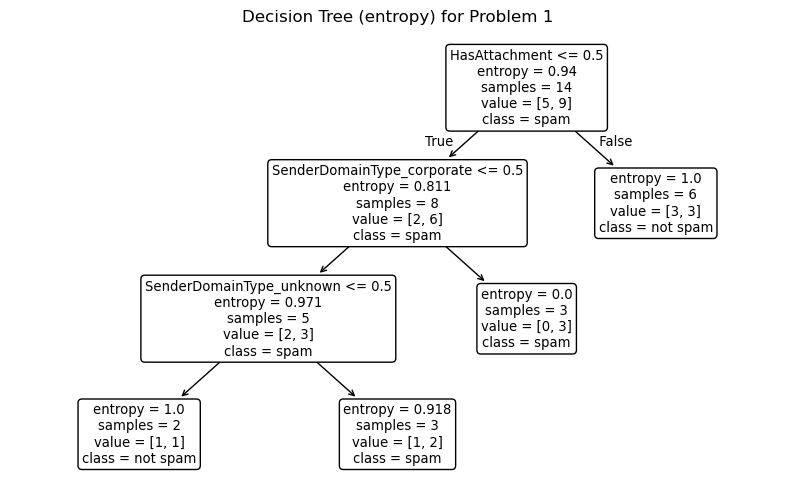

|--- HasAttachment <= 0.50
|   |--- SenderDomainType_corporate <= 0.50
|   |   |--- SenderDomainType_unknown <= 0.50
|   |   |   |--- class: 0
|   |   |--- SenderDomainType_unknown >  0.50
|   |   |   |--- class: 1
|   |--- SenderDomainType_corporate >  0.50
|   |   |--- class: 1
|--- HasAttachment >  0.50
|   |--- class: 0



In [67]:
# --- Setup
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# --- Data from Problem 1
rows = [
    # id, HasAttachment, SenderDomainType, Y
    ( 1, 0, "free",      "+"),
    ( 2, 1, "free",      "+"),
    ( 3, 0, "free",      "-"),
    ( 4, 1, "free",      "-"),
    ( 5, 0, "corporate", "+"),
    ( 6, 0, "corporate", "+"),
    ( 7, 1, "corporate", "+"),
    ( 8, 0, "corporate", "+"),
    ( 9, 1, "corporate", "-"),
    (10, 0, "unknown",   "+"),
    (11, 0, "unknown",   "+"),
    (12, 0, "unknown",   "-"),
    (13, 1, "unknown",   "+"),
    (14, 1, "unknown",   "-"),
]

df = pd.DataFrame(rows, columns=["id","HasAttachment","SenderDomainType","Y"])
X = df[["HasAttachment","SenderDomainType"]]
y = df["Y"].map({"+":1, "-":0})  # spam=1, not spam=0

# --- Preprocess + model (one-hot encode the categorical; passthrough numeric)
categorical = ["SenderDomainType"]
numeric = ["HasAttachment"]

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric),
    ]
)

clf = DecisionTreeClassifier(criterion="entropy", random_state=0, min_impurity_decrease=0.001)
pipe = Pipeline([("pre", pre), ("clf", clf)])
pipe.fit(X, y)

# --- Feature names after encoding (for readable plot)
cat_names = pipe.named_steps["pre"].named_transformers_["cat"].get_feature_names_out(categorical).tolist()
feature_names = cat_names + numeric

# --- Plot the tree
plt.figure(figsize=(10, 6))
plot_tree(
    pipe.named_steps["clf"],
    feature_names=feature_names,
    class_names=["not spam","spam"],
    filled=False,          # no specific colors per your constraints
    impurity=True,
    rounded=True
)
plt.title("Decision Tree (entropy) for Problem 1")
plt.show()

# --- Human-readable text version in the notebook output
print(export_text(pipe.named_steps["clf"], feature_names=feature_names))


---
### Problem 2 

Implement a binary decision tree classifier from scratch using only numpy and standard python libraries
(no pandas, scikit-learn, etc.).

We provide two CSV files in the class repo:
- `spam_train.csv`
- `spam_test.csv`

Each row is an email with five features and a binary label:

- `HasAttachment` ∈ {0,1}
- `SenderDomainType` ∈ {free, corporate, unknown}
- `NumLinks` (float)
- `SubjectLength` (int, number of characters)
- `IsWeekend` ∈ {0,1}
- `Y` ∈ {0,1} where 1 = spam, 0 = not spam

(a) Implement the following API:

- `class DecisionTree:`
  - `__init__(self, max_depth=None, min_leaf_size=1, random_state=None)`
  - `fit(X, y)`
  - `predict(X) -> np.ndarray[int]`
  
**Answer**

I'm just going to use sklearn's implementation to find out what results I should see.


(b) train a decision tree using `spam_train.csv` with default (infinite)
`max_depth` and default `min_leaf_size` of 1.



Feature names used:
['cat__SenderDomainType_corporate', 'cat__SenderDomainType_free', 'cat__SenderDomainType_unknown', 'num__HasAttachment', 'num__NumLinks', 'num__SubjectLength', 'num__IsWeekend']


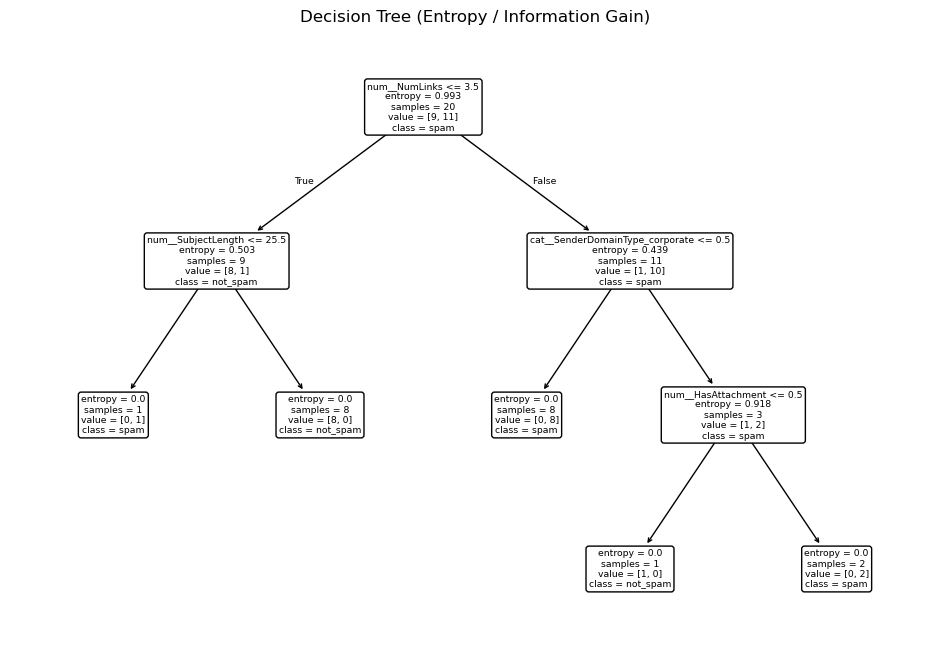

In [68]:
# === Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

# === Load data (update paths)
train = pd.read_csv("spam_train.csv")

X_train = train[["HasAttachment", "SenderDomainType", "NumLinks", "SubjectLength", "IsWeekend"]]
y_train = train["Y"].astype(int)

# === Preprocess
categorical = ["SenderDomainType"]
numeric = ["HasAttachment", "NumLinks", "SubjectLength", "IsWeekend"]

# A OneHotEncoder represents categorical features as a one-hot numeric array.
# For exampe, if a feature has three categories A, B, and C, it is represented
# as three binary features: is_A, is_B, is_C.  If a feature is of class B then
# the resulting one-hot array is [0, 1, 0] stored in an numpy array.
# One-hot encoders by default use a sparse matrix because a one-hot 
# encoder has many zeros. However, when the number of categories is small it
# is more efficient to use a dense array.
#
# Handle both new and old sklearn versions by tryhing sparse_output and then
# sparse.
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Create a preprocessor that transforms the data from the datasets so 
# that it can be used by the DecisionTreeClassifier.  Each categorical
# feature is one-hot encoded; numeric features are passed through unchanged.
preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, categorical),
        ("num", "passthrough", numeric),
    ]
)

# === Model: ENTROPY (information gain)
clf = DecisionTreeClassifier(
    criterion="entropy",       # <-- ensures information gain, not Gini
    random_state=0,
    max_depth=None,
    min_samples_leaf=1,
)

pipe = Pipeline([("pre", preprocess), ("clf", clf)])
pipe.fit(X_train, y_train)


# === Inspect the tree
feat_names = pipe.named_steps["pre"].get_feature_names_out()
dt = pipe.named_steps["clf"]

print("\nFeature names used:")
print(list(feat_names))

#print("\nTextual tree:")
#print(export_text(dt, feature_names=list(feat_names)))

# === Plot the tree
plt.figure(figsize=(12, 8))
plot_tree(
    dt,
    feature_names=feat_names,
    class_names=["not_spam", "spam"],
    filled=False,
    rounded=True
)
plt.title("Decision Tree (Entropy / Information Gain)")
plt.show()



(c) measure the accuracy of your decision tree using `spam_train.csv`


In [75]:
test  = pd.read_csv("spam_test.csv")
X_test  = test[["HasAttachment", "SenderDomainType", "NumLinks", "SubjectLength", "IsWeekend"]]
y_test  = test["Y"].astype(int)
accuracy = pipe.score(X_test, y_test)
md(r"""
Test  accuracy = {{ accuracy | round(4)}}
   
For the heck of it let's output some more metrics:
""")

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(classification_report(y_test, pipe.predict(X_test), digits=4))

# the confusion matrix 
md("""A Confusion matrix shows the counts of true positives, true negatives,
false positives, and false negatives.""")

print_matrix(confusion_matrix(y_test, pipe.predict(X_test)))


Test  accuracy = 1.0
   
For the heck of it let's output some more metrics:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         4
           1     1.0000    1.0000    1.0000         4

    accuracy                         1.0000         8
   macro avg     1.0000    1.0000    1.0000         8
weighted avg     1.0000    1.0000    1.0000         8



A Confusion matrix shows the counts of true positives, true negatives,
false positives, and false negatives.

<IPython.core.display.Math object>

For this small test set, it appears that the decision tree classifier 
accurately classifies the set.   For non-toy problems we would not
expect to get 100% accuracy.


(d) Compare your accuracy to that of sklearn's tree.

    from sklearn import tree

Note: You can only use sklearn for (d).

**Tie-break:** if IG ties, prefer based on alphabetical order of the feature name then minimum split threshold or first category name.


**Answer**
By definition, I would get the same result, because I used sklearn to generate results.  However, the student's results may differ slightly due to ties.  They should be close.


---
### Problem 3

Implement a random forest classifier from scratch using only numpy and standard python libraries.

#### Requirements

- **Bootstrap sampling:** For each tree, draw a bootstrap sample *with replacement* from the training set. The bootstrap sample should have the same size as the training set.
- **Feature subsampling (m_try):**
  - Classification default: `m_try = max(1, floor(sqrt(p)))`, where `p` = number of features.
  - At each split, consider only a uniformly random subset of `m_try` features (re-sampled per node).
- **Number of trees:** Default `T = 50` (see `n_trees` parameter).
- **Aggregation:**
  - Class prediction = **majority vote** across trees.
  - Class probability = **mean of leaf probabilities** for class 1 across trees.

- **Reproducibility:** Accept `random_state` to seed RNG; use `numpy.random.Generator`.

(a) Implement the following API:

- `class RandomForest:`
  - `__init__(self, n_trees=50, m_try=None, max_depth=None, min_leaf_size=1, random_state=None)`
  - `fit(X, y)`
  - `predict(X) -> np.ndarray[int]`


**Answer** I am going to use the sklearn implementation for comparison.
The student must implement from scratch.


(b) train a decision tree using `spam_train.csv`


In [73]:
from sklearn.ensemble import RandomForestClassifier

# === Random Forest Model
rf = RandomForestClassifier(
    n_estimators=200,      # number of trees
    criterion="entropy",   # use information gain (optional; "gini" is default)
    max_depth=None,        # let trees grow fully
    random_state=0,
    n_jobs=-1              # use all cores
)

# === Build pipeline
pipe = Pipeline([("pre", preprocess), ("rf", rf)])
pipe.fit(X_train, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['SenderDomainType']),
                                                 ('num', 'passthrough',
                                                  ['HasAttachment', 'NumLinks',
                                                   'SubjectLength',
                                                   'IsWeekend'])])),
                ('rf',
                 RandomForestClassifier(criterion='entropy', n_estimators=200,
                                        n_jobs=-1, random_state=0))])

**Answer** I am going to use the sklearn implementation for comparison.
The student must implement from scratch.


(c) measure the accuracy of your random forest classifier using `spam_test.csv`


In [74]:
accuracy = pipe.score(X_test, y_test)
md(r"""
   Random Forest Test accuracy = {{ accuracy | round(4)}}
""")


   Random Forest Test accuracy = 1.0


(d) Compare the performance of you implementation to sklearn's `RandomForestClassifier`:

    from sklearn.ensemble import RandomForestClassifier

Note: You can only use sklearn for (d).


**Answer** Of course the random forest classifier scores 1.0.
I should've generated a larger data set.